# Assignment 4: Sampling and Model Interpretability
-----------------------------------

**Dr. Dave Wanik - OPIM 5512: Data Science Using Python - University of Connecticut**

-----------------------------------


**Your Name Here:** Adam Syed

Put your sampling and interpretability skills to the test!

You will build a classification model using a sampling technique of your choice (oversampling, undersampling or SMOTE - I'm not testing how good your model is for this assignment, just that you know how to interpret the model!). We will use CA housing since you have some experience with this from tree-based models. You can use any classification model we have covered in class (DTC, RFC, GBC or logistic regression.)

# Rubric
* (10 points) I've already made your data 'imbalanced' with the 75th percentile. Split the raw data into train and test partition with an 80/20 split. Then use a sampling technique (oversampling, undersampling, SMOTE) on the train data. Important: do not change the class imbalance in the test partition! Count values of each class before and after your sampling to confirm your understanding of how the sampling worked. Your new train data should be more or less balanced, while the test data is still imbalanced. This allows for fair evaluation of the model.

Then, using your fitted model, you will:
* (40 points) Print the top 3 features (using permutation importance with 15 repeats) as a boxplot (like we do in class.)
* (40 points) Create the partial dependence plots for the top 3 features (you may opt to use the `num_grid_points=10` argument if your code is taking a long time to run). Customize the plots so that the Y axis is consistent on each of the three plots and remember that the Y axis is showing the change in predicted probability.
* (10 points) Write five meaningful bullets about what you see in the plots and tables. Does anything surprise you?
  * **Optional:** Potential with issues concerning correlated predictors (read here for a cool way on how to address this: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html)?

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('/Users/adamyeeter/OPIM 5512 Python/Data/california_housing_train.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


And we will recode the target variable to a classification problem.

In [2]:
df['median_house_value'] = np.where(df['median_house_value'] > np.percentile(df['median_house_value'], q=75), 1, 0)
df['median_house_value'].value_counts()

0    12753
1     4247
Name: median_house_value, dtype: int64

In [3]:
from sklearn.model_selection import train_test_split

y = df['median_house_value']
X = df.drop('median_house_value', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 2735566)
y_train.value_counts()

0    10206
1     3394
Name: median_house_value, dtype: int64

# Sampling

In [4]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

oversample = RandomOverSampler(sampling_strategy='minority')

X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

Counter(y_train_over)

Counter({0: 10206, 1: 10206})

# Model and Metrics

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(max_iter=1000, random_state=2735566)

LR = LR.fit(X_train_over, y_train_over)

train_preds_LR = LR.predict(X_train_over) 
test_preds_LR = LR.predict(X_test) 

In [6]:
confusion_matrix(y_train_over, train_preds_LR)

array([[8361, 1845],
       [1869, 8337]])

In [7]:
confusion_matrix(y_test, test_preds_LR)

array([[2070,  477],
       [ 161,  692]])

In [8]:
trainReport_LR = classification_report(y_train_over, train_preds_LR)
print(trainReport_LR)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82     10206
           1       0.82      0.82      0.82     10206

    accuracy                           0.82     20412
   macro avg       0.82      0.82      0.82     20412
weighted avg       0.82      0.82      0.82     20412



In [9]:
testReport_LR = classification_report(y_test, test_preds_LR)
print(testReport_LR)

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      2547
           1       0.59      0.81      0.68       853

    accuracy                           0.81      3400
   macro avg       0.76      0.81      0.78      3400
weighted avg       0.84      0.81      0.82      3400



# Interpretability

## Permutation Importance

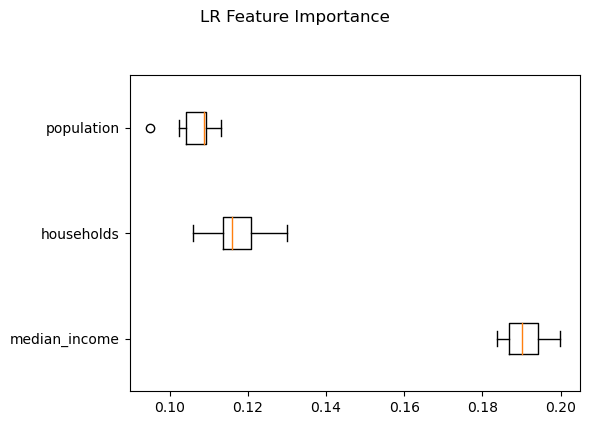

In [10]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

clf = LR

result = permutation_importance(clf, X_test, y_test, n_repeats=15,
                                random_state=2735566)

perm_sorted_idx = result.importances_mean.argsort()[::-1]

top_3_idx = perm_sorted_idx[:3]

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.boxplot(result.importances[top_3_idx].T, vert=False,
            labels=X.columns[top_3_idx])
fig.suptitle('LR Feature Importance', y=1.05)
fig.tight_layout()
plt.show()

## Partial Dependence

In [11]:
train_X_df = pd.DataFrame(X_train_over, columns=X.columns)
train_X_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-120.06,36.72,32.0,981.0,237.0,736.0,249.0,1.8000
1,-117.95,33.98,15.0,16042.0,2602.0,7732.0,2552.0,5.6716
2,-121.94,37.32,46.0,2451.0,472.0,1163.0,448.0,4.8519
3,-122.68,41.15,32.0,817.0,206.0,224.0,89.0,3.6310
4,-122.27,37.84,52.0,2436.0,541.0,1015.0,478.0,1.7250


In [12]:
from pycebox.ice import ice, ice_plot
clfdf = ice(data=train_X_df,
            column='median_income',
                   predict=clf.predict,
                    num_grid_points=10)
np.shape(clfdf)

/Users/adamyeeter/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(10, 13600)

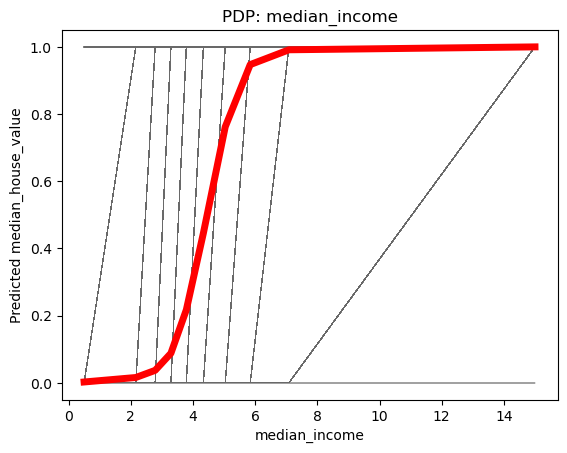

In [13]:
ice_plot(clfdf, c='dimgray', linewidth=0.3,
                  plot_pdp=True, 
         pdp_kwargs={'linewidth': 5, 'color':'red'})
plt.title('PDP: median_income')
plt.ylabel('Predicted median_house_value')
plt.xlabel('median_income');
plt.show()

/Users/adamyeeter/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


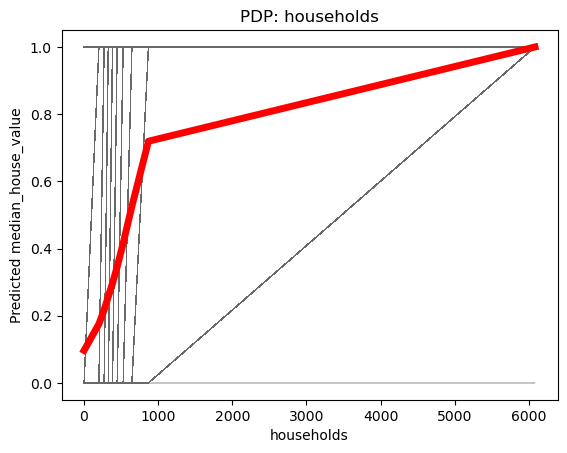

In [14]:
from pycebox.ice import ice, ice_plot
clfdf = ice(data=train_X_df,
            column='households',
                   predict=clf.predict,
                    num_grid_points=10)

ice_plot(clfdf, c='dimgray', linewidth=0.3,
                  plot_pdp=True, 
         pdp_kwargs={'linewidth': 5, 'color':'red'})
plt.title('PDP: households')
plt.ylabel('Predicted median_house_value')
plt.xlabel('households');
plt.show()

/Users/adamyeeter/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


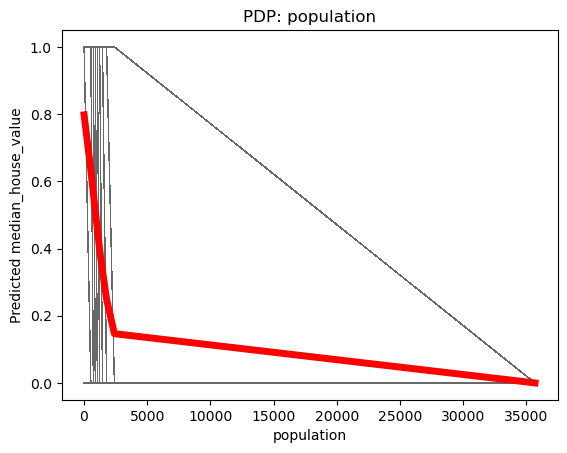

In [15]:
from pycebox.ice import ice, ice_plot
clfdf = ice(data=train_X_df,
            column='population',
                   predict=clf.predict,
                    num_grid_points=10)

ice_plot(clfdf, c='dimgray', linewidth=0.3,
                  plot_pdp=True, 
         pdp_kwargs={'linewidth': 5, 'color':'red'})
plt.title('PDP: population')
plt.ylabel('Predicted median_house_value')
plt.xlabel('population');
plt.show()

# Conclusions

1. In the permutation importance boxplots, I see that the three most important features are median_income, households, and population.I was not surprised to see median_income as the top feature overall, however I am surprised to see population in the top 3. 

2. As population increases, the predicted median_house_value decreases sharply at first and then decreases gradually. I was able to see this through the partial dependence plot.

3. As median_income increases, the predicted median_house_value increases and then starts to plateau at a predicted median_house_value of 1 and a median_income value of 6. This is not a surpise to me as these two variables seem to have an obvious correlation.

4. As the households feature increases, the predicted median_house_value increases sharply at first and then increases gradually.

5. In the classification report for the test set, the precision was very high (0.93) when predicting the median_house_value below the median. However, the precision was low (0.59) when predicting the median_house_value above the median.